# Core: Train Model One-versus-All
Train a One-vs-All model, primarily intended for roads.
  
Date: 2018-12-06   
Author: Peter Kerins

### Import statements
(may be over-inclusive)

In [1]:
# typical, comprehensive imports
import warnings
warnings.filterwarnings('ignore')
#
import os
import sys
import json
import itertools
import pickle
from pprint import pprint
#
import numpy as np
import shapely
import cartopy
import geojson
import fiona
import gdal
import h5py
get_ipython().magic(u'matplotlib inline')
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler 
import ogr, gdal
from keras.models import load_model
import math
from keras.utils import to_categorical
from keras.models import load_model
from keras import models
from keras import layers
from keras.layers import Dropout
from keras.utils import to_categorical
from skimage import measure
from skimage import filters
from scipy import stats

import tensorflow as tf

import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Input, Add, Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint, History

import collections

import descarteslabs as dl
print dl.places.find('illinois') ## TEST

ULU_REPO = os.environ["ULU_REPO"]
sys.path.append(ULU_REPO+'/utils')
print sys.path

import util_descartes
import util_ml
import util_rasters
import util_vectors
import util_workflow
import util_keras


Using TensorFlow backend.


[{u'name': u'Illinois', u'id': 85688697, u'placetype': u'region', u'bbox': [-91.512974, 36.970298, -87.019935, 42.508302], u'path': u'continent:north-america_country:united-states_region:illinois', u'slug': u'north-america_united-states_illinois'}]
['', '/usr/lib/python2.7', '/usr/lib/python2.7/plat-x86_64-linux-gnu', '/usr/lib/python2.7/lib-tk', '/usr/lib/python2.7/lib-old', '/usr/lib/python2.7/lib-dynload', '/home/Taufiq.Rashid/.local/lib/python2.7/site-packages', '/usr/local/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages', '/usr/lib/python2.7/dist-packages/PILcompat', '/usr/lib/python2.7/dist-packages/gtk-2.0', '/usr/local/lib/python2.7/dist-packages/IPython/extensions', '/home/Taufiq.Rashid/.ipython', '/home/Peter.Kerins/UrbanLandUse/utils']


### Set key variables

In [2]:
data_root='/data/phase_iii/'

bands=['blue','green','red','nir','swir1','swir2','alpha']; suffix='BGRNS1S2A'  # S2, Lx
resolution=5  # Lx:15 S2:10

ndvi_bands = ['raw'];

tile_resolution = resolution
tile_size = 256
tile_pad = 16

label_suffix = 'aue-roads'

# NYU AoUE land use/land cover categories
category_label = {0:'Open Space',1:'Non-Residential',\
                   2:'Residential Atomistic',3:'Residential Informal Subdivision',\
                   4:'Residential Formal Subdivision',5:'Residential Housing Project',\
                   6:'Roads',7:'Study Area',8:'Labeled Study Area',254:'No Data',255:'No Label'}

### Specify training data parameters

In [3]:
window = 17    # width of square window

cats_map = {}
cats_map[0] = 0
cats_map[1] = 1
cats_map[2] = 4
cats_map[3] = 4
cats_map[4] = 4
cats_map[5] = 4
cats_map[6] = 6

categories = [0,1,4,6]

bands_vir=bands[:-1]
bands_sar=None#s1_bands
bands_ndvi=ndvi_bands
bands_ndbi=None
bands_osm=None

haze_removal = False

epochs = 100
batch_size = 128
balancing = None
model_id = 'Roads_Sin_OPQRSTU'
notes = '1vAll models at 5m res, bilinear resampling, roads heavy training data,green images from 2017 for Singrauli'

In [4]:
stack_label, feature_count = util_workflow.build_stack_label(
        bands_vir=bands_vir,
        bands_sar=bands_sar,
        bands_ndvi=bands_ndvi,
        bands_ndbi=bands_ndbi,
        bands_osm=bands_osm,)
print stack_label, feature_count

vir+ndvi 7


### Build training data "superset"
The "superset" of training data used to actually train a model can be a combination of any number of stored training data sets built from particular input stacks. These constituent sets can come from one or many cities. The only requirement is that they are all consistent in construction, ie are built from the same input stack.

In [5]:
reload(util_workflow)

place_images = {}
place_images['singrauli'] = ['O','P','Q','R','S','T','U']

X_train_raw, Y_train_raw, X_valid_raw, Y_valid_raw = util_workflow.load_datasets(place_images, data_root, label_suffix, stack_label, window, resolution=resolution)

calculate total size of training and validation supersets
/data/phase_iii/singrauli/singrauli_train_aue-roads_5m_vir+ndvi_17w_O.pkl
/data/phase_iii/singrauli/singrauli_valid_aue-roads_5m_vir+ndvi_17w_O.pkl
(133073, 2023) (133073,) (57032, 2023) (57032,)
/data/phase_iii/singrauli/singrauli_train_aue-roads_5m_vir+ndvi_17w_P.pkl
/data/phase_iii/singrauli/singrauli_valid_aue-roads_5m_vir+ndvi_17w_P.pkl
(133073, 2023) (133073,) (57032, 2023) (57032,)
/data/phase_iii/singrauli/singrauli_train_aue-roads_5m_vir+ndvi_17w_Q.pkl
/data/phase_iii/singrauli/singrauli_valid_aue-roads_5m_vir+ndvi_17w_Q.pkl
(133073, 2023) (133073,) (57032, 2023) (57032,)
/data/phase_iii/singrauli/singrauli_train_aue-roads_5m_vir+ndvi_17w_R.pkl
/data/phase_iii/singrauli/singrauli_valid_aue-roads_5m_vir+ndvi_17w_R.pkl
(133073, 2023) (133073,) (57032, 2023) (57032,)
/data/phase_iii/singrauli/singrauli_train_aue-roads_5m_vir+ndvi_17w_S.pkl
/data/phase_iii/singrauli/singrauli_valid_aue-roads_5m_vir+ndvi_17w_S.pkl
(133073, 2

### Prepare stored training data for machine learning

Scale training data

In [6]:
X_train_raw_scaled, X_valid_raw_scaled, scaler = util_ml.scale_learning_data(X_train_raw, X_valid_raw)
print X_train_raw_scaled.shape

(931511, 2023) (399224, 2023)
(931511, 2023)


In [7]:
del X_train_raw, X_valid_raw

In [8]:
X_train = X_train_raw_scaled.reshape((X_train_raw_scaled.shape[0],feature_count,window,window))
X_valid = X_valid_raw_scaled.reshape((X_valid_raw_scaled.shape[0],feature_count,window,window))

In [9]:
del X_train_raw_scaled, X_valid_raw_scaled

Remap category labels to reduced typology  
(Theoretically could leave this for the subsequent binary remapping)

In [10]:
Y_train = Y_train_raw.copy()
Y_valid = Y_valid_raw.copy()

for k, v in cats_map.items():
    Y_train[Y_train_raw==k] = v
    Y_valid[Y_valid_raw==k] = v

### Train and score a 1vAll model for each LULC category

In [11]:
print("DEFAULT:",K.image_data_format())
K.set_image_data_format('channels_first')
print("UPDATED:",K.image_data_format())

('DEFAULT:', 'channels_last')
('UPDATED:', 'channels_first')


Create network, train fast

In [12]:
# OUTPUT NODES = 1

reload(util_ml)
reload(util_keras)

NB_FILTERS_1=32
NB_FILTERS_2=64

cats=[0,1]

cat=6
# create binary data
Y_t_bin = util_ml.make_binary(Y_train, cat, silent=True)
Y_v_bin = util_ml.make_binary(Y_valid, cat, silent=True)

#balance
X_t_balanced, Y_t_balanced = util_ml.balance_binary(X_train, Y_t_bin, max_ratio=2.5, silent=False)    

# create model
weights = util_ml.generate_category_weights_simple(Y_t_balanced)
print 'weights', weights
#     loss = util_keras.weighted_categorical_crossentropy(weights)

network = util_keras.build_model(util_keras.doubleres_block,input_shape=X_train.shape[-3:],output_nodes=1)
util_keras.compile_network(network, 'binary_crossentropy', metrics=['binary_accuracy'], LR=0.001)

weights_label='WCC_weights.best'

filepath = data_root+'models/'+model_id+'_'+weights_label+'.hdf5'
patience=1
estop_cb=EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=0, mode='auto')
save_best_cb=ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=True, 
                             mode='auto', period=1)
history_cb=History()

history_fast = network.fit(X_t_balanced, Y_t_balanced, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_v_bin),shuffle=True,callbacks=[estop_cb,save_best_cb,history_cb])
###Changed by Taufiq

min: 168714 ; max: 762797
(590499, 7, 17, 17)
421785 168714
(590499,)
[0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 0]
        0       1
0  421785  168714
weights [1.0, 2.5]
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 7, 17, 17)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 17, 17)   5632        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 32, 17, 17)   2048        input_1[0][0]                    
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32

Train on 590499 samples, validate on 399224 samples
Epoch 1/100
590499/590499 [==============================] - 163s 277us/step - loss: 0.4999 - binary_accuracy: 0.7476 - val_loss: 0.4098 - val_binary_accuracy: 0.8091
Epoch 2/100
590499/590499 [==============================] - 161s 273us/step - loss: 0.4180 - binary_accuracy: 0.7985 - val_loss: 0.3400 - val_binary_accuracy: 0.8459
Epoch 3/100
590499/590499 [==============================] - 161s 273us/step - loss: 0.3713 - binary_accuracy: 0.8250 - val_loss: 0.2954 - val_binary_accuracy: 0.8676
Epoch 4/100
590499/590499 [==============================] - 163s 276us/step - loss: 0.3422 - binary_accuracy: 0.8412 - val_loss: 0.2674 - val_binary_accuracy: 0.8809
Epoch 5/100
590499/590499 [==============================] - 163s 277us/step - loss: 0.3215 - binary_accuracy: 0.8521 - val_loss: 0.2526 - val_binary_accuracy: 0.8876
Epoch 6/100
590499/590499 [==============================] - 164s 278us/step - loss: 0.3063 - binary_accuracy: 0.

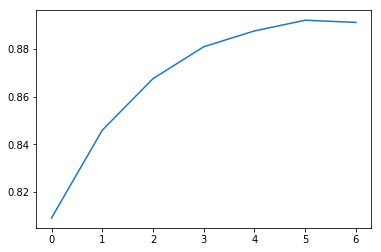

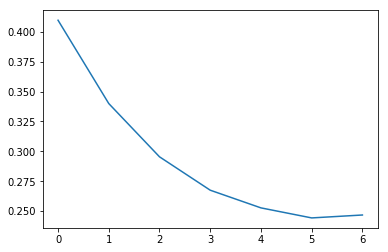

In [13]:
plt.plot(history_fast.history['val_binary_accuracy'])
plt.show()
plt.plot(history_fast.history['val_loss'])
plt.show()

In [ ]:
# score model
print "evaluate training"
Yhat_t_prob = network.predict(X_t_balanced)
Yhat_t = np.rint(Yhat_t_prob).astype(int).reshape(Yhat_t_prob.shape[0])
print Yhat_t_prob[0:20]
print Yhat_t[0:20]
#Yhat_t = Yhat_t_prob.argmax(axis=-1)
train_confusion = util_ml.calc_confusion(Yhat_t,Y_t_balanced,cats)
train_recalls, train_precisions, train_accuracy = util_ml.calc_confusion_details(train_confusion)
print train_recalls, train_precisions
print

print "evaluate validation"
Yhat_v_prob = network.predict(X_valid)
Yhat_v = np.rint(Yhat_v_prob).astype(int).reshape(Yhat_v_prob.shape[0])
print Yhat_v_prob[0:20]
print Yhat_v[0:20]
#Yhat_v = Yhat_v_prob.argmax(axis=-1)
valid_confusion = util_ml.calc_confusion(Yhat_v,Y_v_bin,cats)
valid_recalls, valid_precisions, valid_accuracy = util_ml.calc_confusion_details(valid_confusion)
print valid_recalls, valid_precisions
print

evaluate training
[[1.2782753e-04]
 [1.1486548e-03]
 [8.7902671e-01]
 [7.5245909e-02]
 [2.6924765e-06]
 [2.3325635e-03]
 [5.6274675e-02]
 [9.9948126e-01]
 [1.2733188e-02]
 [9.9969029e-01]
 [9.3052648e-03]
 [9.8825359e-01]
 [2.4352228e-05]
 [4.0906281e-05]
 [8.7000126e-01]
 [3.2233674e-02]
 [9.9266934e-01]
 [5.9441793e-01]
 [6.6537873e-06]
 [9.6970201e-01]]
[0 0 1 0 0 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1]
0 421785
1 168714
[[390072  31713]
 [ 24527 144187]]
590499 534259 0.9047585177959658
[0.9248124 0.8546238] [0.9408416 0.8197101]

evaluate validation
[[4.1565061e-02]
 [1.7840478e-01]
 [1.0255206e-03]
 [1.1220242e-02]
 [3.1655233e-03]
 [2.0986827e-04]
 [4.1280496e-01]
 [2.9239336e-03]
 [7.6457065e-01]
 [9.3178070e-01]
 [9.9232413e-02]
 [9.2096543e-01]
 [1.0377216e-03]
 [8.4007974e-05]
 [9.9013197e-01]
 [8.9444667e-03]
 [9.5958579e-01]
 [4.2188849e-02]
 [9.9999821e-01]
 [3.2627586e-08]]
[0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 0 1 0 1 0]
0 325528
1 73696
[[296319  29209]
 [ 14237  59459]]
399224 355778

Reconstitute network, train slow

In [ ]:
#weights_label='WCC_weights.best'
# rebuild network
network=util_keras.build_model(util_keras.doubleres_block,input_shape=X_train.shape[-3:],output_nodes=1)
# load weights from fast learning
filepath = data_root+'models/'+model_id+'_'+weights_label+'.hdf5'
network.load_weights(filepath)
weights_label='WCC_weights_slow.best'
callbacks, history_path = util_keras.create_callbacks(data_root, model_id, weights_label=weights_label, patience=4)

util_keras.compile_network(network, 'binary_crossentropy', metrics=['binary_accuracy'], LR=0.0001)
# train slow
history_slow = network.fit(X_t_balanced, Y_t_balanced, batch_size=batch_size, epochs=epochs, validation_data=(X_valid, Y_v_bin),shuffle=True,callbacks=callbacks)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 7, 17, 17)    0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 32, 17, 17)   5632        input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_13 (Conv2D)              (None, 32, 17, 17)   2048        input_2[0][0]                    
__________________________________________________________________________________________________
activation_11 (Activation)      (None, 32, 17, 17)   0           conv2d_11[0][0]                  
__________________________________________________________________________________________________
activation

590499/590499 [==============================] - 163s 276us/step - loss: 0.2597 - binary_accuracy: 0.8834 - val_loss: 0.2145 - val_binary_accuracy: 0.9056
Epoch 2/100
590499/590499 [==============================] - 161s 273us/step - loss: 0.2467 - binary_accuracy: 0.8893 - val_loss: 0.2096 - val_binary_accuracy: 0.9072
Epoch 3/100
590499/590499 [==============================] - 161s 273us/step - loss: 0.2399 - binary_accuracy: 0.8929 - val_loss: 0.2053 - val_binary_accuracy: 0.9098
Epoch 4/100
590499/590499 [==============================] - 162s 274us/step - loss: 0.2332 - binary_accuracy: 0.8960 - val_loss: 0.2041 - val_binary_accuracy: 0.9107
Epoch 5/100
590499/590499 [==============================] - 162s 274us/step - loss: 0.2305 - binary_accuracy: 0.8976 - val_loss: 0.1988 - val_binary_accuracy: 0.9126
Epoch 6/100
590499/590499 [==============================] - 164s 277us/step - loss: 0.2261 - binary_accuracy: 0.9002 - val_loss: 0.1970 - val_binary_accuracy: 0.9138
Epoch 7/10

In [ ]:
plt.plot(history_slow.history['val_binary_accuracy'])
plt.show()
plt.plot(history_slow.history['val_loss'])
plt.show()

In [ ]:
# score model
print "evaluate training"
Yhat_t_prob = network.predict(X_t_balanced)
Yhat_t = np.rint(Yhat_t_prob).astype(int).reshape(Yhat_t_prob.shape[0])
# print Yhat_t_prob[0:20]
# print Yhat_t[0:20]
#Yhat_t = Yhat_t_prob.argmax(axis=-1)
train_confusion = util_ml.calc_confusion(Yhat_t,Y_t_balanced,cats)
train_recalls, train_precisions, train_accuracy = util_ml.calc_confusion_details(train_confusion)
# print train_recalls, train_precisions
print

print "evaluate validation"
Yhat_v_prob = network.predict(X_valid)
Yhat_v = np.rint(Yhat_v_prob).astype(int).reshape(Yhat_v_prob.shape[0])
# print Yhat_v_prob[0:20]
# print Yhat_v[0:20]
#Yhat_v = Yhat_v_prob.argmax(axis=-1)
valid_confusion = util_ml.calc_confusion(Yhat_v,Y_v_bin,cats)
valid_recalls, valid_precisions, valid_accuracy = util_ml.calc_confusion_details(valid_confusion)
# print valid_recalls, valid_precisions
print

In [ ]:
# Calculate f-score
beta = 2
train_f_score = (beta**2 + 1) * train_precisions * train_recalls / ( (beta**2 * train_precisions) + train_recalls )
train_f_score_open = None#train_f_score[0] 
train_f_score_nonres = None#train_f_score[1]  
train_f_score_res = None#train_f_score[2]  
train_f_score_roads = None#train_f_score[3]  
train_f_score_average = np.mean(train_f_score)

# Calculate f-score
valid_f_score = (beta**2 + 1) * valid_precisions * valid_recalls / ( (beta**2 * valid_precisions) + valid_recalls )
valid_f_score_open = None#valid_f_score[0] 
valid_f_score_nonres = None#valid_f_score[1] 
valid_f_score_res = None#valid_f_score[2] 
valid_f_score_roads = None# valid_f_score[3] 
valid_f_score_average = np.mean(valid_f_score)

# expanding lists to match expected model_record stuff
train_recalls_expanded = [train_recalls[0],None,None,train_recalls[1]]
valid_recalls_expanded = [valid_recalls[0],None,None,valid_recalls[1]]
train_precisions_expanded = [train_precisions[0],None,None,train_precisions[1]]
valid_precisions_expanded = [valid_precisions[0],None,None,valid_precisions[1]]

In [ ]:
scaler_filename = data_root+'models/'+model_id+'_scaler.pkl'
#model_filename  = data_root+'models/'+model_id+'_SVM.pkl'
network_filename = data_root+'models/'+model_id+'.hd5'

if os.path.exists(scaler_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+scaler_filename+')'
#elif os.path.exists(model_filename):
#    print 'Aborting all pickle operations: file already exists at specified path ('+model_filename+')'
elif os.path.exists(network_filename):
    print 'Aborting all pickle operations: file already exists at specified path ('+network_filename+')'
else:
    print scaler_filename
#    print model_filename
    print network_filename
    pickle.dump(scaler, open(scaler_filename, 'wb'))
#    pickle.dump(model, open(model_filename, 'wb'))
    network.save(network_filename)
    # tracking only occurs if all saves are successful
    util_workflow.record_model_creation(
        model_id, notes, place_images, label_suffix, resolution, stack_label, feature_count, window, cats_map, balancing, 
        network.get_config(), epochs, batch_size,
        train_confusion, train_recalls_expanded, train_precisions_expanded, train_accuracy,
        train_f_score_open, train_f_score_nonres, train_f_score_res, train_f_score_roads, train_f_score_average,
        valid_confusion, valid_recalls_expanded, valid_precisions_expanded, valid_accuracy,
        valid_f_score_open, valid_f_score_nonres, valid_f_score_res, valid_f_score_roads, valid_f_score_average,)